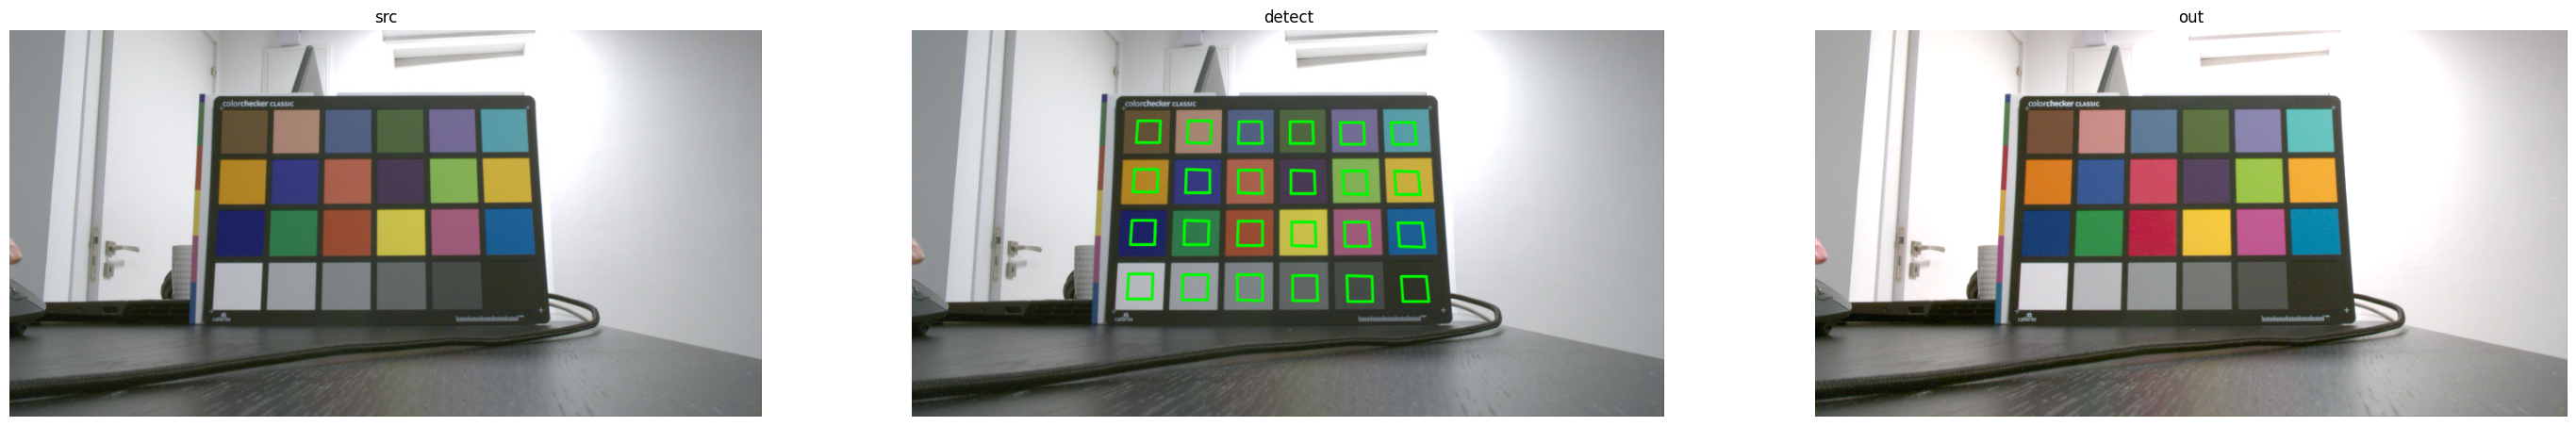

In [2]:
import cv2
import numpy as np
from utils import show_images

# 图片来源：https://github.com/opencv/opencv_extra/tree/4.x/testdata/cv/mcc
src = cv2.imread('./image/mcc/mcc_ccm_test.jpg', -1)

detector = cv2.mcc.CCheckerDetector.create()

# 也可以用神经网络模型来检测，检测的时候参数要设置为 useNet
# detector.setNet()
# isCheck = detector.process(src, chartType=cv2.mcc.MCC24, useNet=True)

# 检测，一共可以有三个种类，MCC24、SG140、VINYL18
isCheck = detector.process(src, chartType=cv2.mcc.MCC24)

if isCheck:
    # getList 返回数组，getBest 则返回数组里面最有可能的
    # checkers = detector.getListColorChecker()
    now_checker = detector.getBestColorChecker()

    # CCheckerDraw 画图，就这两个方法；create 这里的 color 和 thickness 都是默认值，不指定也可以
    cdraw_src = np.copy(src)
    cdraw = cv2.mcc.CCheckerDraw.create(now_checker, color=(0, 250, 0), thickness=2)
    cdraw.draw(cdraw_src)

    # 获取各个色块的颜色，排列顺序是 RGB，注意要 reshape 成 (3, 24)，并且除以 255!!
    # getChartsRGB -> (72, 5)；24*3，各自表示 p_size, average, stddev, max, min，这里就只拿 average 即可
    src_rgb = now_checker.getChartsRGB()[:, 1]

    # 建立 CCM 模型
    # 重要：CCM 模型需要传入当前拍摄色卡的颜色，要求是：(24,1,3)、RGB排列、[0,1]
    src_rgb = src_rgb.reshape((24, 1, 3)) / 255
    ccm_model = cv2.ccm.ColorCorrectionModel(src_rgb, constcolor=cv2.ccm.COLORCHECKER_MACBETH)

    # 设置参数，算出矩阵。有许多参数，这里就简单写一个意思意思（其实这个也不用写，默认就是 3x3）
    ccm_model.setCCM_TYPE(cv2.ccm.CCM_3x3)
    ccm_model.run()
    ccm_matrix = ccm_model.getCCM()

    # 可以获取校正前后的 RGB；校正的 Loss 等
    # print(ccm_model.getLoss(), ccm_model.get_dst_rgbl())
    
    # 校正图片。很重要：输入和输出图片都是 [0, 1] 和 RGB 排列！
    out = ccm_model.infer(cv2.cvtColor(src, cv2.COLOR_BGR2RGB)/255)
    out = cv2.cvtColor( (out * 255).clip(0, 255).astype(np.uint8), cv2.COLOR_RGB2BGR )

    show_images([
        ('src', src),
        ('detect', cdraw_src),
        ('out', out)
    ], colnum=3)